# Homework 2 : CUAHSI VU : Snow Hydrology

This notebook will be relatively short because this where the real work starts and most of the notebook will be written by you (or at least that is the plan). We'll do three exercises in this homework:

* Homework 1 exercise 1: Change the snow layering scheme

* Homework 1 exercise 2: Change the albedo formulation and albedo parameters

* Homework 1 exercise 3: Change the parameters controlling drainage through the snow pack


## Homework 1 Exercise 1

### Setup

Make sure that the CUES site is set up before you run this notebook (see `install_summa_model_configurations.ipynb`).

We'll import some of the python modules that you are likely to need right up front. Note that you only need to do this once in a notebook. As long as you are working in the same session, the modules will remain loaded for the duration of that session.

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import pysumma as ps

We'll also set some variables to make sure that everyone is using the same setup

In [90]:
executable = 'summa.exe'
filemanager = '/home/jovyan/data/cues/summa_setup/settings/file_manager_cues.txt'

### Change the snow layering scheme

Snow models represent a snow pack as one or more layers of snow and keep track of how much water is stored in each layer (snow water equivalent or SWE) as well as other state variables such as temperature. The model then tracks the time evolution of these state variables in each layer as well as the fluxes of water and energy between the layers.

In SUMMA you can choose between two different methods to combine and sub-divide snow layers. This behavior is controlled by the `snowLayers` variable in the [SUMMA decisions file](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/#infile_model_decisions) and can take one of two values, either `CLM_2010` or `jrdn1991`. The first refers to how snow layers were handled in the Community Land Model (CLM), while the second refers the snow layering scheme in SNTHERM as describe in  Jordan (1991).

Among others things, the `CLM_2010` only has a limited number of snow layers. The layers store a maximum amount of SWE and when SWE in a layer exceeds that value, a new layer is created. Similarly, when SWE in a layer falls below a minimum SWE, the layer is merged with a neighboring layer. Once the maximum number of layers has been created, the deepest layer can grow as deep as it needs to be and acts as snow reservoir with unlimited capacity. The `jrdn1991` scheme on the other hand keeps creating additional layers as the snow pack grows in depth.

Here we will do four different simulations:

* SUMMA with `CLM_2010`
* SUMMA with `jrdn1991`
* SUMMA with `CLM_2010`, but we will configure it to act as a two layer model (the default version uses five snow layers)
* SUMMA with `CLM_2010`, a two layer model and a thick top layer.

So now it is up to you. Just to refresh your memory we'll show you how to get started and then will provide some hints along the way.

#### SUMMA with CLM_2010

Create a simulation object. The path for the SUMMA code and the file manager (the SUMMA input file with information about all the other input files) are already defined above. We can use the same file manager file (but different simulation objects) for all the runs, just keep track of what you did.

In [3]:
s_clm = ps.Simulation(executable, filemanager)

# Shorten the simulation length
s_clm.manager['simStartTime'] = '2010-10-01 00:00'
s_clm.manager['simEndTime'] = '2012-10-01 00:00'

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new variables
for var in layer_vars:
    s_clm.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_clm.output_control.options])
for var in all_vars:
    s_clm.output_control[var] = output_settings

Use a `run_suffix` that uniquely identifies this run so that you can keep your runs apart, for example `CLM_2010`, and run the model. If you assign the results to its own dataset (e.g. `ds_clm_2010`) and output file (e.g. `file_clm_2010`) it will be easier to gather all the files and upload them to HydroShare (or you can do so one by one, this is all up to you). The run itself will take about a minute.

In [4]:
s_clm.run('local', run_suffix='CLM_2010')

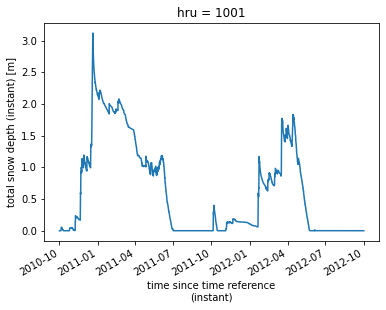

In [5]:
s_clm.output['scalarSnowDepth'].isel(hru=0).plot()

As you can see, the number of layers never exceeds five.

#### SUMMA with jrdn1991

Repeat the exercise with the `jrdn1991` option for `snowLayers`. Examine the differences in the snow layers themselves, but also in other characteristics of snow pack evolution. In SUMMA, all other options will be the same between these two simulations unless you change things explicitly.

In [6]:
s_jrdn = ps.Simulation(executable, filemanager)
s_jrdn.manager['simStartTime'] = '2010-10-01 00:00'
s_jrdn.manager['simEndTime'] = '2012-10-01 00:00'
s_jrdn.decisions['snowLayers'] = 'jrdn1991'

In [7]:
# Create the new variables
for var in layer_vars:
    s_jrdn.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_clm.output_control.options])
for var in all_vars:
    s_jrdn.output_control[var] = output_settings

In [8]:
s_jrdn.run('local', run_suffix='_jrdn')

In [9]:
print(s_jrdn.status)

Success


#### SUMMA with CLM_2010 configured as a  two layer model

Now change the `snowLayers` option back to `CLM_2010` and configure the model to act as a two layer snow model rather than a five layer snow model. Two layer models are quite common. The surface layer is typically quite thin in these setups to respond quickly to changing atmospheric conditions, while the second layer acts as a snow reservoir with unlimited capacity.

To configure the snow model as a two layer model, we need to change some model parameters. As in the pySUMMA tutorial, we can access and change these parameters with the `local_param_info` attribute of a `Simulation` object.


In [10]:
s_2layer = ps.Simulation(executable, filemanager)
s_2layer.manager['simStartTime'] = '2010-10-01 00:00'
s_2layer.manager['simEndTime'] = '2012-10-01 00:00'
s_2layer.decisions['snowLayers'] = 'CLM_2010'

s_2layer.global_hru_params['zminLayer3'] = 100.0000
s_2layer.global_hru_params['zminLayer4'] = 100.0000
s_2layer.global_hru_params['zminLayer5'] = 100.0000
s_2layer.global_hru_params['zmaxLayer2_lower'] = 1000.0000
s_2layer.global_hru_params['zmaxLayer3_lower'] = 1000.0000
s_2layer.global_hru_params['zmaxLayer4_lower'] = 1000.0000
s_2layer.global_hru_params['zmaxLayer2_upper'] = 1000.0000
s_2layer.global_hru_params['zmaxLayer3_upper'] = 1000.0000
s_2layer.global_hru_params['zmaxLayer4_upper'] = 1000.0000

In [11]:
# Create the new variables
for var in layer_vars:
    s_2layer.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_clm.output_control.options])
for var in all_vars:
    s_2layer.output_control[var] = output_settings

Now go ahead and run the model. 

In [12]:
s_2layer.run('local', run_suffix='_2layer')

In [13]:
print(s_2layer.status)

Success


#### SUMMA with CLM_2010 configured as a two layer model with a thick top layer

One more run with `CLM_2010`, two layers, and a thick top layer. To do this, change the local parameters to

In [14]:
s_thick = ps.Simulation(executable, filemanager)
s_thick.manager['simStartTime'] = '2010-10-01 00:00'
s_thick.manager['simEndTime'] = '2012-10-01 00:00'
s_thick.decisions['snowLayers'] = 'CLM_2010'

s_thick.global_hru_params['zminLayer1'] = 0.050
s_thick.global_hru_params['zminLayer2'] = 0.020
s_thick.global_hru_params['zminLayer3'] = 100.0
s_thick.global_hru_params['zminLayer4'] = 100.0
s_thick.global_hru_params['zminLayer5'] = 100.0
s_thick.global_hru_params['zmaxLayer1_lower'] = 0.2000
s_thick.global_hru_params['zmaxLayer2_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer3_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer4_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer1_upper'] = 0.1500
s_thick.global_hru_params['zmaxLayer2_upper'] = 1000.0
s_thick.global_hru_params['zmaxLayer3_upper'] = 1000.0
s_thick.global_hru_params['zmaxLayer4_upper'] = 1000.0

In [15]:
# Create the new variables
for var in layer_vars:
    s_thick.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_clm.output_control.options])
for var in all_vars:
    s_thick.output_control[var] = output_settings

In [16]:
s_thick.run('local', run_suffix='_thick')

In [17]:
print(s_thick.status)

Success


### Plotting

To examine how these changes impact the model output make some plots. Below is just an example comparing the amount of SWE across the four runs. You may wish to try some other plots, such as the layering plots described in the pySUMMA tutorial.

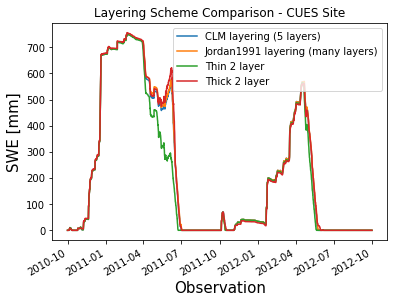

In [18]:
s_clm.output['scalarSWE'].plot(label='CLM layering (5 layers)')
s_jrdn.output['scalarSWE'].plot(label='Jordan1991 layering (many layers)')
s_2layer.output['scalarSWE'].plot(label='Thin 2 layer')
s_thick.output['scalarSWE'].plot(label='Thick 2 layer')

plt.ylabel('SWE [mm]',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.legend()
plt.title('Layering Scheme Comparison - CUES Site')
plt.savefig('layer_comparison.png',bbox_inches='tight',pad_inches=0.3)

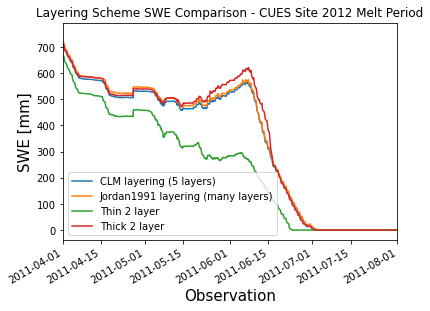

In [19]:
import datetime as dt
s_clm.output['scalarSWE'].plot(label='CLM layering (5 layers)')
s_jrdn.output['scalarSWE'].plot(label='Jordan1991 layering (many layers)')
s_2layer.output['scalarSWE'].plot(label='Thin 2 layer')
s_thick.output['scalarSWE'].plot(label='Thick 2 layer')

plt.xlim(dt.date(2011,4,1),dt.date(2011,8,1))
plt.ylabel('SWE [mm]',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.legend()
plt.title('Layering Scheme SWE Comparison - CUES Site 2012 Melt Period')
plt.savefig('layer_comparison_closeup_melt_2011.png',bbox_inches='tight',pad_inches=0.3)

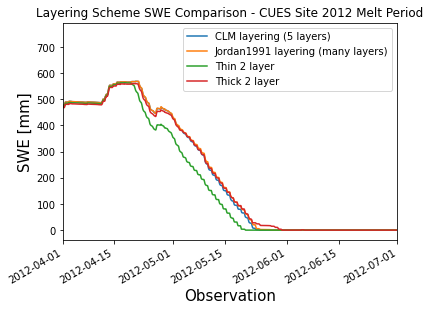

In [20]:
import datetime as dt
s_clm.output['scalarSWE'].plot(label='CLM layering (5 layers)')
s_jrdn.output['scalarSWE'].plot(label='Jordan1991 layering (many layers)')
s_2layer.output['scalarSWE'].plot(label='Thin 2 layer')
s_thick.output['scalarSWE'].plot(label='Thick 2 layer')

plt.xlim(dt.date(2012,4,1),dt.date(2012,7,1))
plt.ylabel('SWE [mm]',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.legend()
plt.title('Layering Scheme SWE Comparison - CUES Site 2012 Melt Period')
plt.savefig('layer_comparison_closeup_melt_2012.png',bbox_inches='tight',pad_inches=0.3)

In [21]:
s_clm.output['scalarSWE']

<xarray.DataArray 'scalarSWE' (time: 17545, hru: 1)>
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])
Coordinates:
  * time     (time) datetime64[ns] 2010-10-01 ... 2012-10-01
  * hru      (hru) int64 1001
Attributes:
    long_name:  snow water equivalent (instant)
    units:      kg m-2

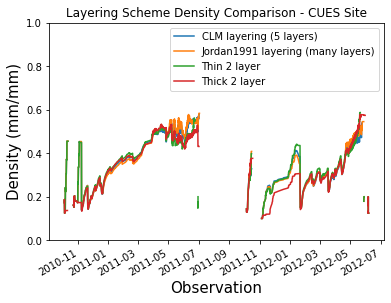

In [22]:

clm_density = s_clm.output['scalarSWE']/(s_clm.output['scalarSnowDepth']*1000)#.rolling(time=100, center=True).mean().dropna("time")
jrdn_density = s_jrdn.output['scalarSWE']/(s_jrdn.output['scalarSnowDepth']*1000)#.rolling(time=100, center=True).mean().dropna("time")
twolayer_density = s_2layer.output['scalarSWE']/(s_2layer.output['scalarSnowDepth']*1000)#.rolling(time=100, center=True).mean().dropna("time")
thick_density = s_thick.output['scalarSWE']/(s_thick.output['scalarSnowDepth']*1000)#.rolling(time=100, center=True).mean().dropna("time")

clm_density.plot(label='CLM layering (5 layers)')
jrdn_density.plot(label='Jordan1991 layering (many layers)')
twolayer_density.plot(label='Thin 2 layer')
thick_density.plot(label='Thick 2 layer')

plt.ylabel('Density (mm/mm)',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.ylim(0,1)
plt.legend()
plt.title('Layering Scheme Density Comparison - CUES Site')
plt.savefig('density.png')

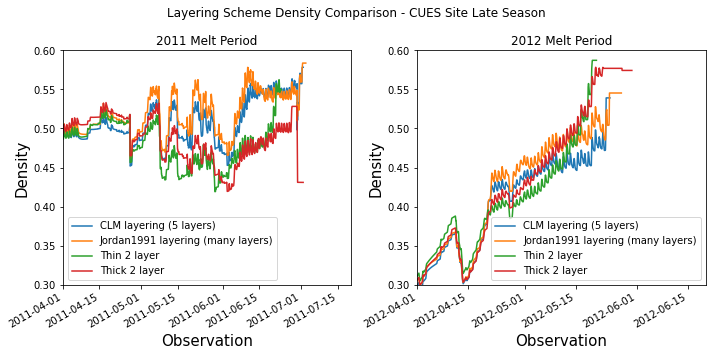

In [23]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)

clm_density = s_clm.output['scalarSWE']/(s_clm.output['scalarSnowDepth']*1000)#.rolling(time=12).mean().dropna("time")
jrdn_density = s_jrdn.output['scalarSWE']/(s_jrdn.output['scalarSnowDepth']*1000)#.rolling(time=12).mean().dropna("time")
twolayer_density = s_2layer.output['scalarSWE']/(s_2layer.output['scalarSnowDepth']*1000)#.rolling(time=12).mean().dropna("time")
thick_density = s_thick.output['scalarSWE']/(s_thick.output['scalarSnowDepth']*1000)#.rolling(time=12).mean().dropna("time")

clm_density.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_density.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_density.plot(ax=ax[0],label='Thin 2 layer')
thick_density.plot(ax=ax[0],label='Thick 2 layer')
ax[0].set_ylabel('Density',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_ylim(0.3,0.6)
ax[0].set_xlim(dt.date(2011,4,1),dt.date(2011,7,20))
ax[0].set_title('2011 Melt Period')
ax[0].legend()

clm_density.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_density.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_density.plot(ax=ax[1],label='Thin 2 layer')
thick_density.plot(ax=ax[1],label='Thick 2 layer')
ax[1].set_ylabel('Density',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_ylim(0.3,0.6)
ax[1].set_xlim(dt.date(2012,4,1),dt.date(2012,6,20))
ax[1].set_title('2012 Melt Period')
ax[1].legend()
fig.suptitle('Layering Scheme Density Comparison - CUES Site Late Season')


fig.savefig('layer_comparison_depth_melt.png')

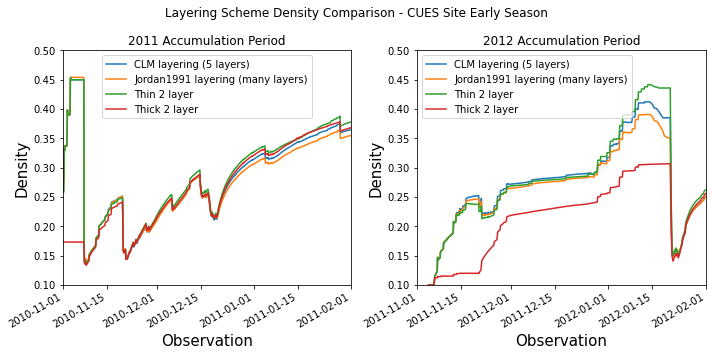

In [24]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)

clm_density = s_clm.output['scalarSWE']/(s_clm.output['scalarSnowDepth']*1000)#.rolling(time=100).mean().dropna("time")
jrdn_density = s_jrdn.output['scalarSWE']/(s_jrdn.output['scalarSnowDepth']*1000)#.rolling(time=100).mean().dropna("time")
twolayer_density = s_2layer.output['scalarSWE']/(s_2layer.output['scalarSnowDepth']*1000)#.rolling(time=100).mean().dropna("time")
thick_density = s_thick.output['scalarSWE']/(s_thick.output['scalarSnowDepth']*1000)#.rolling(time=100).mean().dropna("time")

clm_density.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_density.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_density.plot(ax=ax[0],label='Thin 2 layer')
thick_density.plot(ax=ax[0],label='Thick 2 layer')
ax[0].set_ylabel('Density',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_ylim(0.1,0.5)
ax[0].set_xlim(dt.date(2010,11,1),dt.date(2011,2,1))
ax[0].set_title('2011 Accumulation Period')
ax[0].legend()

clm_density.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_density.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_density.plot(ax=ax[1],label='Thin 2 layer')
thick_density.plot(ax=ax[1],label='Thick 2 layer')
ax[1].set_ylabel('Density',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_ylim(0.1,0.5)
ax[1].set_xlim(dt.date(2011,11,1),dt.date(2012,2,1))
ax[1].set_title('2012 Accumulation Period')
ax[1].legend()
fig.suptitle('Layering Scheme Density Comparison - CUES Site Early Season')

fig.savefig('layer_comparison_depth_accum.png')

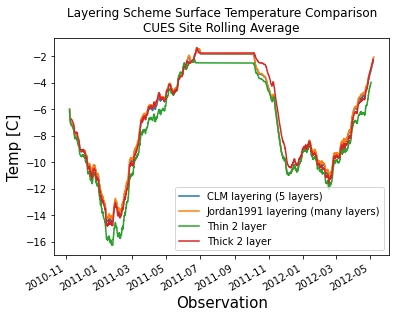

In [25]:

clm_sst = (s_clm.output['scalarSurfaceTemp'].where(s_clm.output['scalarSurfaceTemp']<=273.15,
                                                   drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
jrdn_sst = (s_jrdn.output['scalarSurfaceTemp'].where(s_jrdn.output['scalarSurfaceTemp']<=273.15,
                                                     drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
twolayer_sst = (s_2layer.output['scalarSurfaceTemp'].where(s_2layer.output['scalarSurfaceTemp']<=273.15,
                                                           drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
thick_sst = (s_thick.output['scalarSurfaceTemp'].where(s_thick.output['scalarSurfaceTemp']<=273.15,
                                                       drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")

clm_sst.plot(label='CLM layering (5 layers)')
jrdn_sst.plot(label='Jordan1991 layering (many layers)')
twolayer_sst.plot(label='Thin 2 layer')
thick_sst.plot(label='Thick 2 layer')

plt.ylabel('Temp [C]',fontsize=15)
plt.xlabel('Observation',fontsize=15)

plt.legend()
plt.title('Layering Scheme Surface Temperature Comparison\nCUES Site Rolling Average')
plt.savefig('temperature.png')

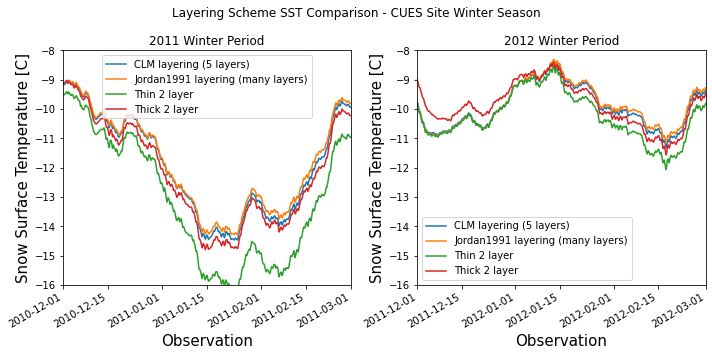

In [71]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)
clm_sst = (s_clm.output['scalarSurfaceTemp'].where(s_clm.output['scalarSurfaceTemp']<=273.15,
                                                   drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
jrdn_sst = (s_jrdn.output['scalarSurfaceTemp'].where(s_jrdn.output['scalarSurfaceTemp']<=273.15,
                                                     drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
twolayer_sst = (s_2layer.output['scalarSurfaceTemp'].where(s_2layer.output['scalarSurfaceTemp']<=273.15,
                                                           drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")
thick_sst = (s_thick.output['scalarSurfaceTemp'].where(s_thick.output['scalarSurfaceTemp']<=273.15,
                                                       drop=True)-273.15).rolling(time=1000, center=True).mean().dropna("time")

clm_sst.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_sst.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_sst.plot(ax=ax[0],label='Thin 2 layer')
thick_sst.plot(ax=ax[0],label='Thick 2 layer')

ax[0].set_ylabel('Snow Surface Temperature [C]',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_xlim(dt.date(2010,12,1),dt.date(2011,3,1))
ax[0].set_title('2011 Winter Period')
ax[0].set_ylim(-16,-8)
ax[0].legend()

clm_sst.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_sst.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_sst.plot(ax=ax[1],label='Thin 2 layer')
thick_sst.plot(ax=ax[1],label='Thick 2 layer')

ax[1].set_ylabel('Snow Surface Temperature [C]',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_xlim(dt.date(2011,12,1),dt.date(2012,3,1))
ax[1].set_title('2012 Winter Period')
ax[1].set_ylim(-16,-8)
ax[1].legend()
fig.suptitle('Layering Scheme SST Comparison - CUES Site Winter Season')

fig.savefig('layer_comparison_sst.png')

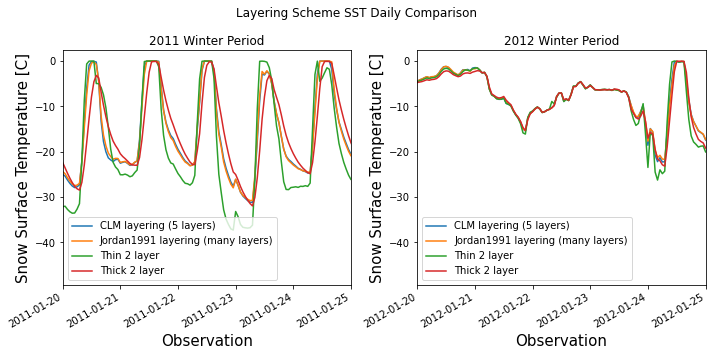

In [28]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)
clm_sst = (s_clm.output['scalarSurfaceTemp'].where(s_clm.output['scalarSurfaceTemp']<=273.15,
                                                   drop=True)-273.15)
jrdn_sst = (s_jrdn.output['scalarSurfaceTemp'].where(s_jrdn.output['scalarSurfaceTemp']<=273.15,
                                                     drop=True)-273.15)
twolayer_sst = (s_2layer.output['scalarSurfaceTemp'].where(s_2layer.output['scalarSurfaceTemp']<=273.15,
                                                           drop=True)-273.15)
thick_sst = (s_thick.output['scalarSurfaceTemp'].where(s_thick.output['scalarSurfaceTemp']<=273.15,
                                                       drop=True)-273.15)

clm_sst.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_sst.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_sst.plot(ax=ax[0],label='Thin 2 layer')
thick_sst.plot(ax=ax[0],label='Thick 2 layer')

ax[0].set_ylabel('Snow Surface Temperature [C]',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_xlim(dt.date(2011,1,20),dt.date(2011,1,25))
ax[0].set_title('2011 Winter Period')
ax[0].legend()

clm_sst.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_sst.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_sst.plot(ax=ax[1],label='Thin 2 layer')
thick_sst.plot(ax=ax[1],label='Thick 2 layer')

ax[1].set_ylabel('Snow Surface Temperature [C]',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_xlim(dt.date(2012,1,20),dt.date(2012,1,25))
ax[1].set_title('2012 Winter Period')
ax[1].legend()
fig.suptitle('Layering Scheme SST Daily Comparison')

fig.savefig('layer_comparison_sst_D.png')

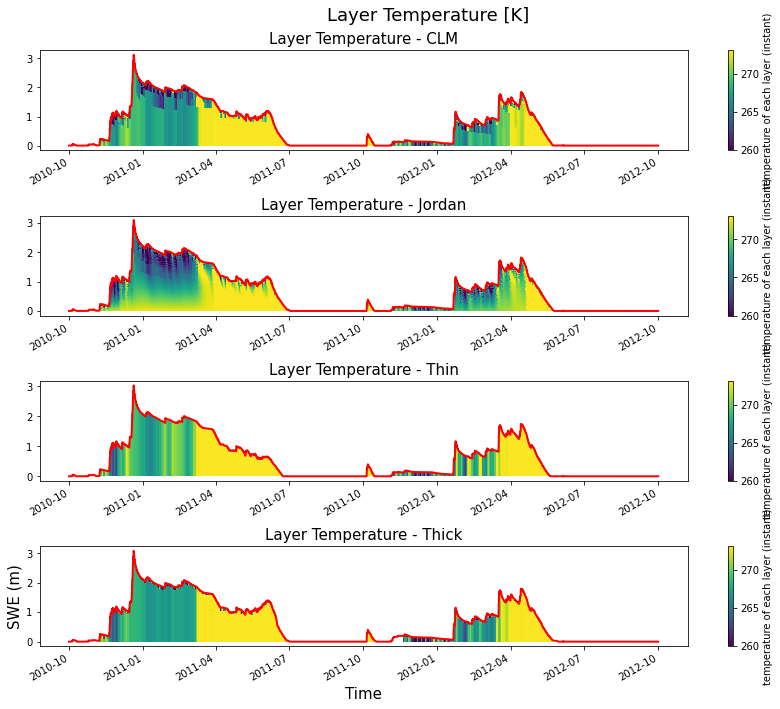

In [88]:
# layering
import pysumma.plotting as psp
fig, axes = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True)
fig.suptitle('Layer Temperature [K]', size=18)
depth = s_clm.output.isel(hru=0)['iLayerHeight']
temp = s_clm.output.isel(hru=0)['mLayerTemp']
psp.layers(temp, depth,
           ax=axes[0],
           variable_range=[260, 273.15],
           plot_soil=False,
           plot_snow=True)
           
s_clm.output['scalarSnowDepth'].plot(color='red', linewidth=2,ax=axes[0])
axes[0].set_xlabel('', size=15)
axes[0].set_ylabel('', size=15)
axes[0].set_title('Layer Temperature - CLM', size=15)

depth = s_jrdn.output.isel(hru=0)['iLayerHeight']
temp = s_jrdn.output.isel(hru=0)['mLayerTemp']
psp.layers(temp, depth,
           ax=axes[1],
           variable_range=[260, 273.15],
           plot_soil=False,
           plot_snow=True)
           
s_jrdn.output['scalarSnowDepth'].plot(color='red', linewidth=2,ax=axes[1])
axes[1].set_xlabel('', size=15)
axes[1].set_ylabel('', size=15)
axes[1].set_title('Layer Temperature - Jordan', size=15)

depth = s_2layer.output.isel(hru=0)['iLayerHeight']
temp = s_2layer.output.isel(hru=0)['mLayerTemp']
psp.layers(temp, depth,
           ax=axes[2],
           variable_range=[260, 273.15],
           plot_soil=False,
           plot_snow=True)
           
s_2layer.output['scalarSnowDepth'].plot(color='red', linewidth=2,ax=axes[2])
axes[2].set_xlabel('', size=15)
axes[2].set_ylabel('', size=15)
axes[2].set_title('Layer Temperature - Thin', size=15)

depth = s_thick.output.isel(hru=0)['iLayerHeight']
temp = s_thick.output.isel(hru=0)['mLayerTemp']
psp.layers(temp, depth,
           ax=axes[3],
           variable_range=[260, 273.15],
           plot_soil=False,
           plot_snow=True)
           
s_thick.output['scalarSnowDepth'].plot(color='red', linewidth=2,ax=axes[3])
axes[3].set_xlabel('Time', size=15)
axes[3].set_ylabel('SWE (m)', size=15)
axes[3].set_title('Layer Temperature - Thick', size=15)
fig.savefig('Layer temperatures.png')

In [ ]:
depth = s_2layer.output.isel(hru=0)['iLayerHeight']
temp = s_2layer.output.isel(hru=0)['mLayerTemp']
cax = fig.add_axes([0.15, 0.25, 1, 0.55])
cax.axis('off')
psp.layers(temp, depth,
           plot_soil=False,
           plot_snow=True,
           cbar_kwargs={'colormap':'viridis','label': 'Temperature (K)','ax': cax})
s_2layer.output['scalarSnowDepth'].plot(color='red', linewidth=2)
plt.xlabel('Time', size=15)
plt.ylabel('SWE (m)', size=15)
plt.title('Layer Temperature - Thin', size=15)
plt.savefig('Thin-layer-temp.png')

In [ ]:
depth = s_thick.output.isel(hru=0)['iLayerHeight']
temp = s_thick.output.isel(hru=0)['mLayerTemp']
cax = fig.add_axes([0.15, 0.25, 1, 0.55])
cax.axis('off')
psp.layers(temp, depth,
           plot_soil=False,
           plot_snow=True,
           cbar_kwargs={'colormap':'viridis','label': 'Temperature (K)','ax': cax})
s_thick.output['scalarSnowDepth'].plot(color='red', linewidth=2)
plt.xlabel('Time', size=15)
plt.ylabel('SWE (m)', size=15)
plt.title('Layer Temperature - Thick', size=15)
plt.savefig('Thick-layer-temp.png')

In [59]:
# code adapted from pysumma_howto.ipynb
fig,axs=plt.subplots(2,2,figsize=(8,8),tight_layout=True)
from matplotlib.ticker import MaxNLocator
# used this to convert only to integers https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers-in-matplotlib
    
clm_layert = (s_clm.output['mLayerTemp'])-273.15
jrdn_layert = (s_jrdn.output['mLayerTemp'])-273.15
twolayer_layert = (s_2layer.output['mLayerTemp'])-273.15
thick_layert = (s_thick.output['mLayerTemp'])-273.15

clm_plt = clm_layert.plot(x='time',ax=axs[0,0], cbar_kwargs={'label': 'Temperature (K)'))
clm_plt.set_clim(15,-15)
plt.gca().invert_yaxis()
axs[0,0].set_title('CLM layering (5 layers)\ntemperature [C]')
axs[0,0].set_ylim(4,0)
axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))

jrdn_plt = jrdn_layert.plot(x='time',ax=axs[0,1])
jrdn_plt.set_clim(15,-15)
plt.gca().invert_yaxis()
axs[0,1].set_title('Jordan1991 layer\ntemperature [C]')
axs[0,1].set_ylim(50,0)

twolayer_plt = twolayer_layert.plot(x='time',ax=axs[1,0])
twolayer_plt.set_clim(15,-15)
plt.gca().invert_yaxis()
axs[1,0].set_ylim(1,0)
axs[1,0].set_title('Thin 2 layer\ntemperature [C]')
axs[1,0].yaxis.set_major_locator(MaxNLocator(integer=True))

thick_plt = thick_layert.plot(x='time',ax=axs[1,1])
thick_plt.set_clim(15,-15)
plt.gca().invert_yaxis()
axs[1,1].set_title('Thick 2 layer\ntemperature [C]')
axs[1,1].set_ylim(1,0)
axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))
for ax in [axs[0,0],axs[1,0],axs[0,1],axs[1,1]]:
    ax.set_ylabel('No. of Layers', size=14)
    ax.set_xlabel('Observation', size=14)
    ax.set_xlim((dt.datetime(2011,1,20),dt.datetime(2011,1,25)))

# twolayer_layert.plot(label='Thin 2 layer')
# thick_layert.plot(label='Thick 2 layer')

# plt.ylabel('Temp [C]',fontsize=15)
# plt.xlabel('Observation',fontsize=15)

# plt.legend()
# plt.title('Layering Scheme Surface Temperature Comparison\nCUES Site Rolling Average')
plt.savefig('layer_temp.png')

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (<ipython-input-59-493a87836a72>, line 11)

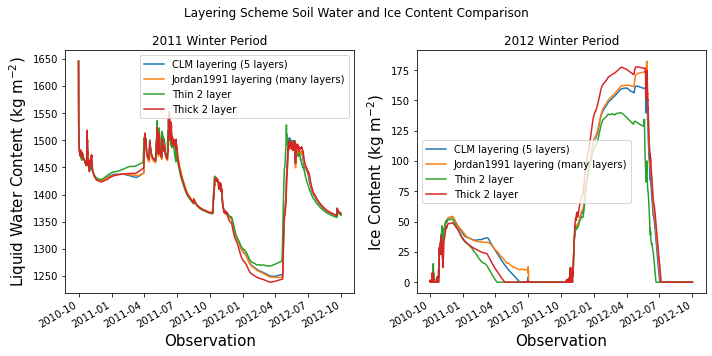

In [34]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)

clm_liq = s_clm.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
jrdn_liq = s_jrdn.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
twolayer_liq = s_2layer.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
thick_liq = s_thick.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")

clm_liq.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_liq.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_liq.plot(ax=ax[0],label='Thin 2 layer')
thick_liq.plot(ax=ax[0],label='Thick 2 layer')

ax[0].set_ylabel(r'Liquid Water Content (kg m$^{-2}$)',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_title('2011 Winter Period')
ax[0].legend()

clm_ice = s_clm.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
jrdn_ice  = s_jrdn.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
twolayer_ice  = s_2layer.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
thick_ice  = s_thick.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")

clm_ice.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_ice.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_ice.plot(ax=ax[1],label='Thin 2 layer')
thick_ice.plot(ax=ax[1],label='Thick 2 layer')

ax[1].set_ylabel(r'Ice Content (kg m$^{-2}$)',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_title('2012 Winter Period')
ax[1].legend()
fig.suptitle('Layering Scheme Soil Water and Ice Content Comparison')

fig.savefig('layer_comparison_ice_water.png')

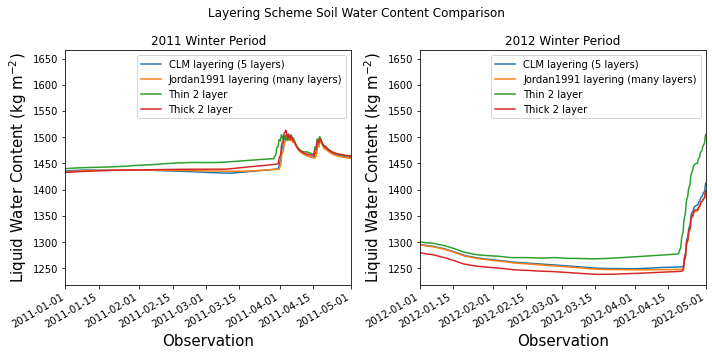

In [35]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)

clm_liq = s_clm.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
jrdn_liq = s_jrdn.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
twolayer_liq = s_2layer.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")
thick_liq = s_thick.output['scalarTotalSoilLiq']#.rolling(time=100, center=True).mean().dropna("time")

clm_liq.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_liq.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_liq.plot(ax=ax[0],label='Thin 2 layer')
thick_liq.plot(ax=ax[0],label='Thick 2 layer')

ax[0].set_ylabel(r'Liquid Water Content (kg m$^{-2}$)',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_xlim(dt.date(2011,1,1),dt.date(2011,5,1))
ax[0].set_title('2011 Winter Period')
ax[0].legend()

clm_liq.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_liq.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_liq.plot(ax=ax[1],label='Thin 2 layer')
thick_liq.plot(ax=ax[1],label='Thick 2 layer')

ax[1].set_ylabel(r'Liquid Water Content (kg m$^{-2}$)',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_xlim(dt.date(2012,1,1),dt.date(2012,5,1))
ax[1].set_title('2012 Winter Period')
ax[1].legend()
fig.suptitle('Layering Scheme Soil Water Content Comparison')

fig.savefig('layer_comparison_water.png')

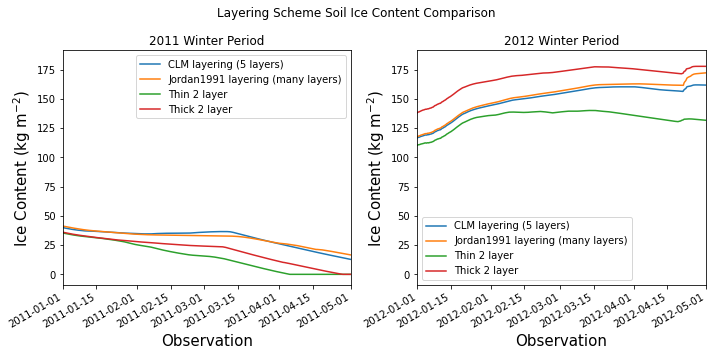

In [36]:
clm_ice = s_clm.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
jrdn_ice  = s_jrdn.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
twolayer_ice  = s_2layer.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")
thick_ice  = s_thick.output['scalarTotalSoilIce']#.rolling(time=100, center=True).mean().dropna("time")

fig,ax = plt.subplots(ncols=2, figsize=(10,5),tight_layout=True)

clm_ice.plot(ax=ax[0],label='CLM layering (5 layers)')
jrdn_ice.plot(ax=ax[0],label='Jordan1991 layering (many layers)')
twolayer_ice.plot(ax=ax[0],label='Thin 2 layer')
thick_ice.plot(ax=ax[0],label='Thick 2 layer')

ax[0].set_ylabel(r'Ice Content (kg m$^{-2}$)',fontsize=15)
ax[0].set_xlabel('Observation',fontsize=15)
ax[0].set_xlim(dt.date(2011,1,1),dt.date(2011,5,1))
ax[0].set_title('2011 Winter Period')
ax[0].legend()

clm_ice.plot(ax=ax[1],label='CLM layering (5 layers)')
jrdn_ice.plot(ax=ax[1],label='Jordan1991 layering (many layers)')
twolayer_ice.plot(ax=ax[1],label='Thin 2 layer')
thick_ice.plot(ax=ax[1],label='Thick 2 layer')

ax[1].set_ylabel(r'Ice Content (kg m$^{-2}$)',fontsize=15)
ax[1].set_xlabel('Observation',fontsize=15)
ax[1].set_xlim(dt.date(2012,1,1),dt.date(2012,5,1))
ax[1].set_title('2012 Winter Period')
ax[1].legend()
fig.suptitle('Layering Scheme Soil Ice Content Comparison')

fig.savefig('layer_comparison_ice.png')

Text(0.5, 1.0, 'Layering Scheme Soil Base Flow Comparison\nCUES Site')

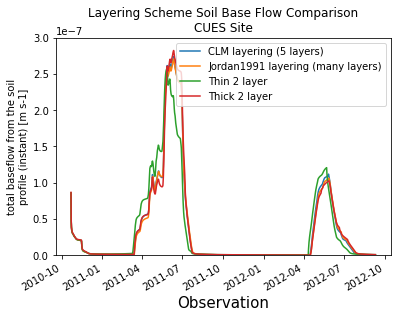

In [37]:
clm_matric = s_clm.output['scalarSoilBaseflow'].rolling(time=1000, center=True).mean().dropna("time")
jrdn_matric = s_jrdn.output['scalarSoilBaseflow'].rolling(time=1000, center=True).mean().dropna("time")
twolayer_matric = s_2layer.output['scalarSoilBaseflow'].rolling(time=1000, center=True).mean().dropna("time")
thick_matric = s_thick.output['scalarSoilBaseflow'].rolling(time=1000, center=True).mean().dropna("time")

clm_matric.plot(label='CLM layering (5 layers)')
jrdn_matric.plot(label='Jordan1991 layering (many layers)')
twolayer_matric.plot(label='Thin 2 layer')
thick_matric.plot(label='Thick 2 layer')

#plt.ylabel('Soil Liquid Content',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.legend()
plt.ylim(0,3e-7)
plt.title('Layering Scheme Soil Base Flow Comparison\nCUES Site')
#plt.savefig('density.png')

<ipython-input-85-8f69405e33e4>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = fig.add_axes([0.15, 0.25, 1, 0.55])
/opt/conda/lib/python3.8/site-packages/pysumma/plotting/hovmoller.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.axes.pcolormesh(x, y, z, cmap=cmap)


False True False True
False True False True


/opt/conda/lib/python3.8/site-packages/pysumma/plotting/hovmoller.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.axes.pcolormesh(x, y, z, cmap=cmap)


False True False True


/opt/conda/lib/python3.8/site-packages/pysumma/plotting/hovmoller.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.axes.pcolormesh(x, y, z, cmap=cmap)


False True False True


/opt/conda/lib/python3.8/site-packages/pysumma/plotting/hovmoller.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.axes.pcolormesh(x, y, z, cmap=cmap)


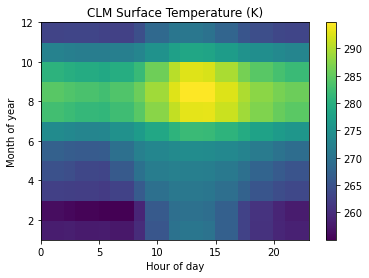

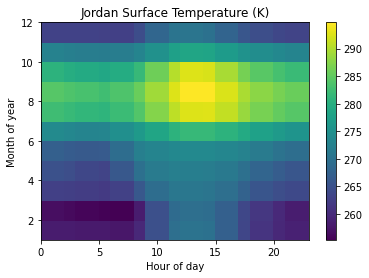

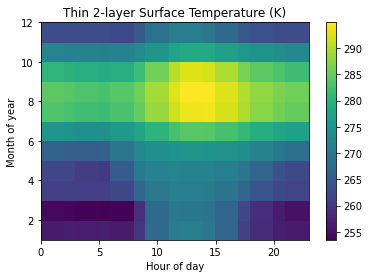

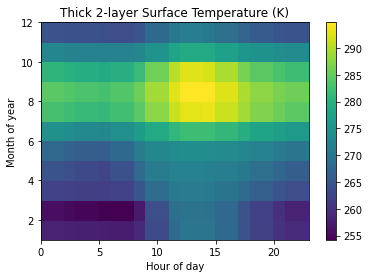

In [85]:
import pysumma.plotting as psp
cax = fig.add_axes([0.15, 0.25, 1, 0.55])
cax.axis('off')

fig, ax = psp.hovmoller(s_clm.output['scalarSurfaceTemp'].isel(hru=0), xdim='hour', ydim='month')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Month of year')
ax.set_title('CLM Surface Temperature (K)')
fig.savefig('surfac_temp_timing_clm.png')
fig, ax2 = psp.hovmoller(s_jrdn.output['scalarSurfaceTemp'].isel(hru=0), xdim='hour', ydim='month')
ax2.set_xlabel('Hour of day')
ax2.set_ylabel('Month of year')
ax2.set_title('Jordan Surface Temperature (K)')
fig.savefig('surfac_temp_timing_jrdn.png')
fig, ax3 = psp.hovmoller(s_2layer.output['scalarSurfaceTemp'].isel(hru=0), xdim='hour', ydim='month')
ax3.set_xlabel('Hour of day')
ax3.set_ylabel('Month of year')
ax3.set_title('Thin 2-layer Surface Temperature (K)')
fig.savefig('surfac_temp_timing_2layer.png')
fig, ax4 = psp.hovmoller(s_thick.output['scalarSurfaceTemp'].isel(hru=0), xdim='hour', ydim='month')
ax4.set_xlabel('Hour of day')
ax4.set_ylabel('Month of year')
ax4.set_title('Thick 2-layer Surface Temperature (K)')
fig.savefig('surfac_temp_timing_thick.png')
    

# plt.savefig('layer_temp.png')

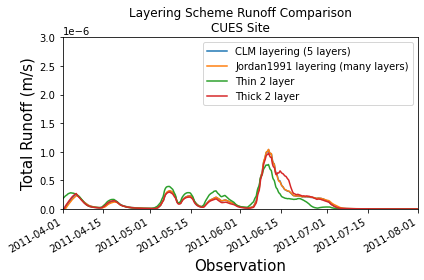

In [39]:

clm_runoff = s_clm.output['scalarTotalRunoff'].rolling(time=100, center=True).mean().dropna("time")
jrdn_runoff = s_jrdn.output['scalarTotalRunoff'].rolling(time=100, center=True).mean().dropna("time")
twolayer_runoff = s_2layer.output['scalarTotalRunoff'].rolling(time=100, center=True).mean().dropna("time")
thick_runoff = s_thick.output['scalarTotalRunoff'].rolling(time=100, center=True).mean().dropna("time")

clm_runoff.plot(label='CLM layering (5 layers)')
jrdn_runoff.plot(label='Jordan1991 layering (many layers)')
twolayer_runoff.plot(label='Thin 2 layer')
thick_runoff.plot(label='Thick 2 layer')

plt.ylabel('Total Runoff (m/s)',fontsize=15)
plt.xlabel('Observation',fontsize=15)
plt.xlim(dt.date(2011,4,1),dt.date(2011,8,1))
plt.ylim(0,3e-6)
plt.legend()
plt.title('Layering Scheme Runoff Comparison\nCUES Site')
plt.tight_layout()
plt.savefig('runoff.png')

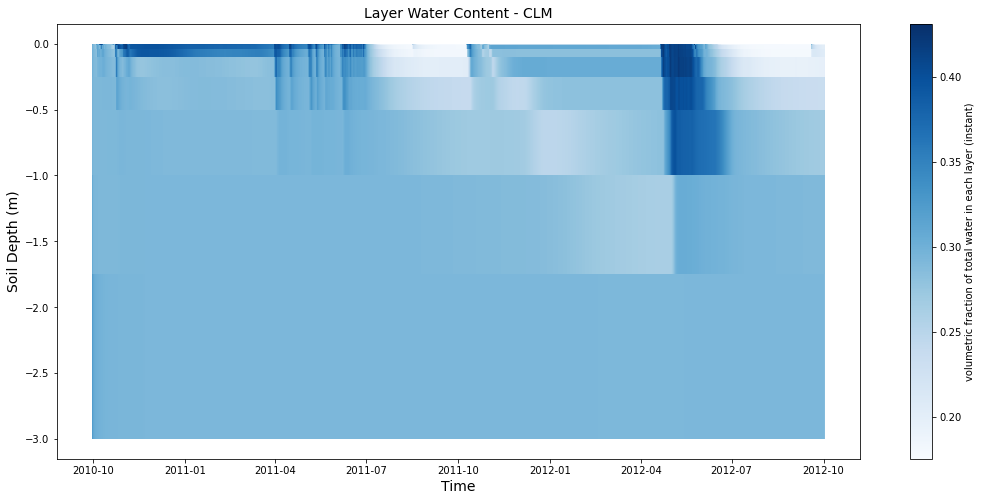

In [40]:
# layering
import pysumma.plotting as psp
#.rolling(time=100).mean().dropna("time")
depth = s_clm.output.isel(hru=0)['iLayerHeight']
frac_wat = s_clm.output.isel(hru=0)['mLayerVolFracWat']
psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=False)
plt.xlabel('Time', size=14)
plt.ylabel('Soil Depth (m)', size=14)
plt.title('Layer Water Content - CLM', size=14)
plt.savefig('CLM-layer-frac-water.png')

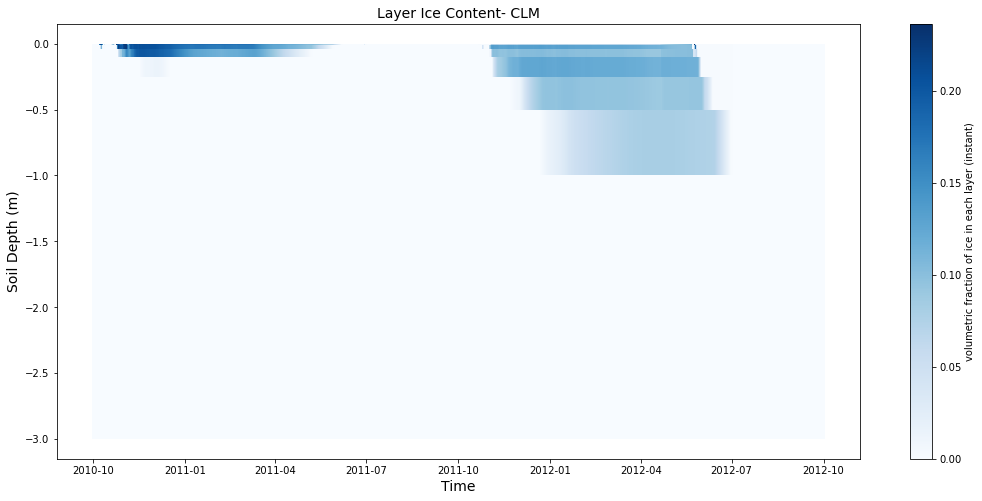

In [41]:
# layering
depth = s_clm.output.isel(hru=0)['iLayerHeight']
frac_ice = s_clm.output.isel(hru=0)['mLayerVolFracIce']
psp.layers(frac_ice, depth, colormap='Blues', plot_soil=True, plot_snow=False)
plt.xlabel('Time', size=14)
plt.ylabel('Soil Depth (m)', size=14)
plt.title('Layer Ice Content- CLM', size=14)
plt.savefig('CLM-layer-frac-ice.png')

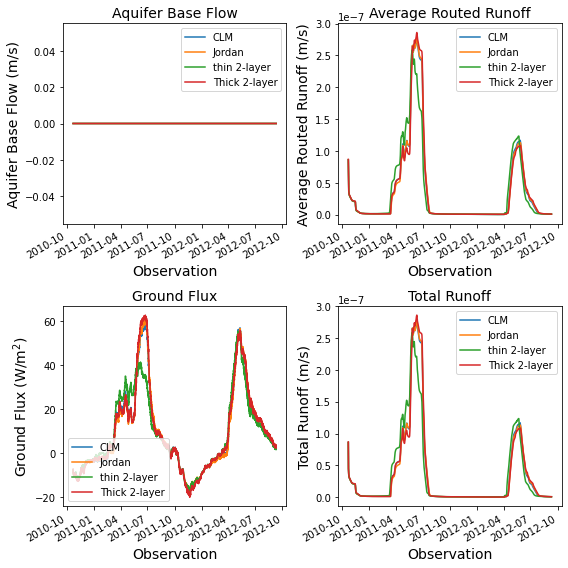

In [42]:
fig,axs=plt.subplots(2,2,figsize=(8,8),tight_layout=True)
from matplotlib.ticker import MaxNLocator
# used this to convert only to integers https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers-in-matplotlib'scalarSoilBaseflow',
    
clm = (s_clm.output['scalarAquiferBaseflow']).rolling(time=1000, center=True).mean().dropna("time")
jrdn = (s_jrdn.output['scalarAquiferBaseflow']).rolling(time=1000, center=True).mean().dropna("time")
twolayer = (s_2layer.output['scalarAquiferBaseflow']).rolling(time=1000, center=True).mean().dropna("time")
thick = (s_thick.output['scalarAquiferBaseflow']).rolling(time=1000, center=True).mean().dropna("time")

clm.plot(x='time',ax=axs[0,0], label='CLM')
jrdn.plot(x='time',ax=axs[0,0], label='Jordan')
twolayer.plot(x='time',ax=axs[0,0], label='thin 2-layer')
thick.plot(x='time',ax=axs[0,0], label='Thick 2-layer')
axs[0,0].set_ylabel('Aquifer Base Flow (m/s)',size = 14)
axs[0,0].set_title('Aquifer Base Flow',size = 14)
axs[0,0].legend()
axs[0,0].set_xlabel('Observation',size = 14)

clm = (s_clm.output['averageRoutedRunoff']).rolling(time=1000, center=True).mean().dropna("time")
jrdn = (s_jrdn.output['averageRoutedRunoff']).rolling(time=1000, center=True).mean().dropna("time")
twolayer = (s_2layer.output['averageRoutedRunoff']).rolling(time=1000, center=True).mean().dropna("time")
thick = (s_thick.output['averageRoutedRunoff']).rolling(time=1000, center=True).mean().dropna("time")

clm.plot(x='time',ax=axs[0,1], label='CLM')
jrdn.plot(x='time',ax=axs[0,1], label='Jordan')
twolayer.plot(x='time',ax=axs[0,1], label='thin 2-layer')
thick.plot(x='time',ax=axs[0,1], label='Thick 2-layer')
axs[0,1].set_ylabel('Average Routed Runoff (m/s)',size = 14)
axs[0,1].set_title('Average Routed Runoff',size = 14)
axs[0,1].set_xlabel('Observation',size = 14)
axs[0,1].legend()

clm = (s_clm.output['scalarGroundNetNrgFlux']).rolling(time=1000, center=True).mean().dropna("time")
jrdn = (s_jrdn.output['scalarGroundNetNrgFlux']).rolling(time=1000, center=True).mean().dropna("time")
twolayer = (s_2layer.output['scalarGroundNetNrgFlux']).rolling(time=1000, center=True).mean().dropna("time")
thick = (s_thick.output['scalarGroundNetNrgFlux']).rolling(time=1000, center=True).mean().dropna("time")

clm.plot(x='time',ax=axs[1,0], label='CLM')
jrdn.plot(x='time',ax=axs[1,0], label='Jordan')
twolayer.plot(x='time',ax=axs[1,0], label='thin 2-layer')
thick.plot(x='time',ax=axs[1,0], label='Thick 2-layer')
axs[1,0].set_ylabel(r'Ground Flux (W/m$^2$)',size = 14)
axs[1,0].set_title('Ground Flux',size = 14)
axs[1,0].legend(loc='lower left')
axs[1,0].set_xlabel('Observation',size = 14)

clm = (s_clm.output['scalarTotalRunoff']).rolling(time=1000, center=True).mean().dropna("time")
jrdn = (s_jrdn.output['scalarTotalRunoff']).rolling(time=1000, center=True).mean().dropna("time")
twolayer = (s_2layer.output['scalarTotalRunoff']).rolling(time=1000, center=True).mean().dropna("time")
thick = (s_thick.output['scalarTotalRunoff']).rolling(time=1000, center=True).mean().dropna("time")

clm.plot(x='time',ax=axs[1,1], label='CLM')
jrdn.plot(x='time',ax=axs[1,1], label='Jordan')
twolayer.plot(x='time',ax=axs[1,1], label='thin 2-layer')
thick.plot(x='time',ax=axs[1,1], label='Thick 2-layer')
axs[1,1].set_ylabel('Total Runoff (m/s)',size = 14)
axs[1,1].set_xlabel('Observation',size = 14)
axs[1,1].set_title('Total Runoff',size = 14)
axs[1,1].legend()


plt.savefig('soil_properties.png')

After you are done, restore the local parameters to the original values, because we will use the same setup in the next notebook. This can be done with the following cell. Basically, we take the initial `s_clm` `Simulation` object and re-write it's configuration which overwrites any changes made by the other simulations we ran. If you try this and it doesn't seem to work, or things go really wrong some other way you can rerun the setup notebook and start with a clean slate.

In [43]:
s_clm._write_configuration()

## On to the next step

That's it for the first part of the first homework as far as the model simulations go. Prof. Lundquist will talk more about the analysis that you need to do on these simulations. You can do the analysis here in this notebook if python is your analysis software of choice or you can upload your output to HydroShare (in NetCDF or csv format) to do additional analysis.

Save this notebook and close the tab. You can also right-click on the file in the left panel if it has a green dot next to it and select "_Shutdown kernel_" from the popup menu to stop the python session that is executing the commands in this notebook. Then open the next notebook: 
`/home/jovyan/data/cuahsi_vu/homework_2/homework_2_B_exercise_2.ipynb`.

## References

* Jordan, R., 1991: A one-dimensional temperature model for a snow cover. Technical documentation for SNTHERM.89. U.S. Army Corps of Engineers Cold Regions Research and Engineering Laboratory, 49 pp.